# Segmentation 

In [3]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from recipes.vessmap import train_vessmap
import torchtrainer

params = {
    # Dataset
    'root': 'I:/datasets_ssd/vessmap',
    'train_val_split': 0.1,                    # Train/validation split
    'transform_type': 'train-geometric',       # Which data augmentation to use
    # Model
    'model_layers': (8,),                      # Number of residual blocks at each layer of the model
    'model_channels': (64,),                   # Number of channels at each layer
    'decoder_layers': (1,),
    'model_type': 'unetv2',                    # Model to use
    # Training
    'epochs': 500,
    'lr': 0.01,
    'batch_size_train': 10,
    'batch_size_valid': 10, 
    'momentum': 0.9,                           # Momentum for optimizer
    'weight_decay': 0.1,
    'seed': 12,                                # Seed for random number generators
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,                    # Power por the polynomial scheduler
    'class_weights': (0.2590, 0.7410),         # Class weights to use for cross entropy calculation
    # Efficiency
    'device': 'cuda',
    'num_workers': 0,                          # Number of workers for the dataloader
    'use_amp': False,                          # Mixed precision
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': 'logs/',                        # Directory for logging metrics and model checkpoints
    'experiment':'unetv2_l_8_c_64',            # Experiment tag
    'save_every':1,                            # Number of epochs between checkpoints     
    'save_best':True,                          # Save model with best validation loss
    'meta': None,                              # Additional metadata to save
    # Other 
    'resume': False                            # Resume from previous training
}

logger, ds_train, ds_valid, model = train_vessmap.run(params)

### View results

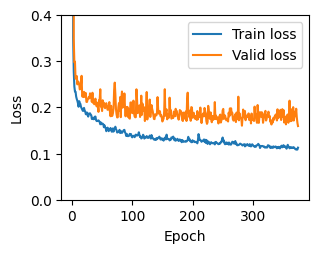

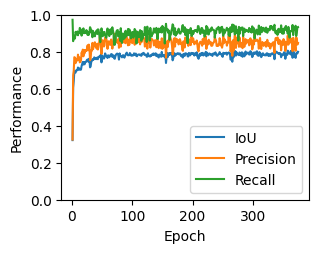

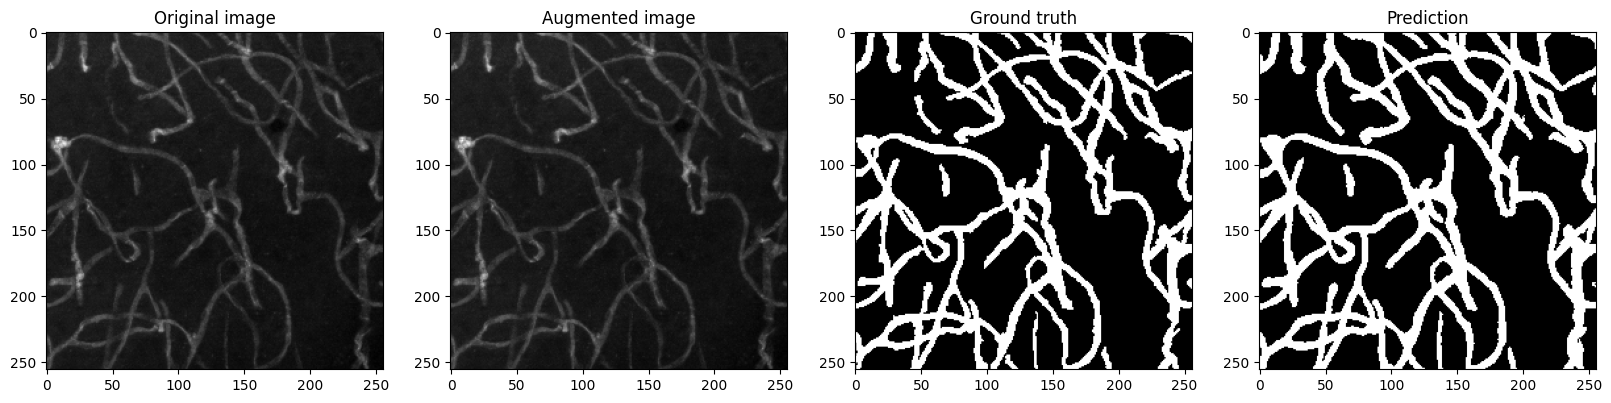

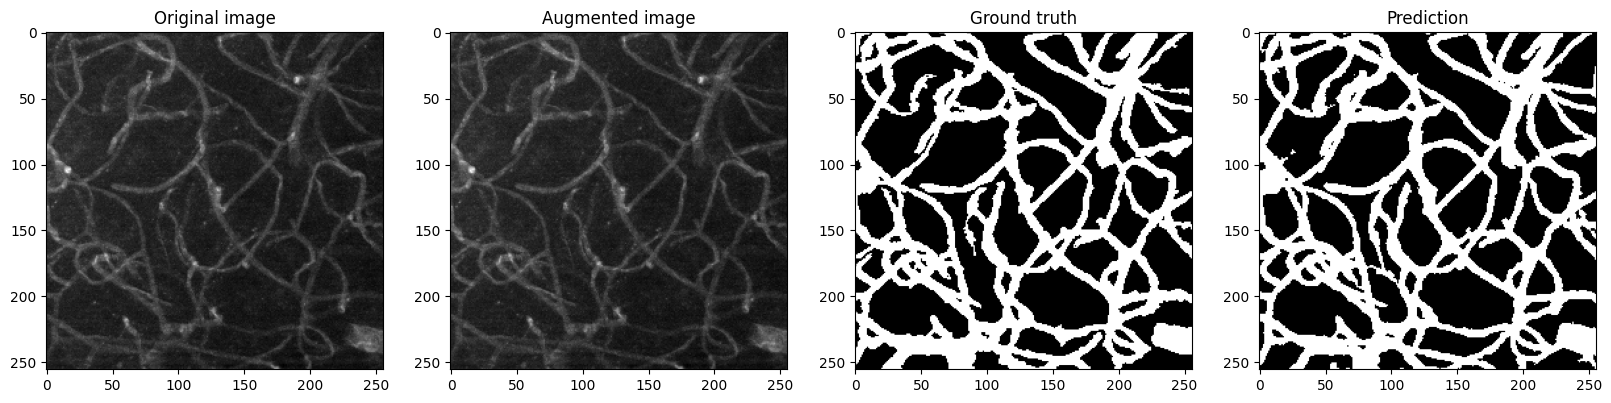

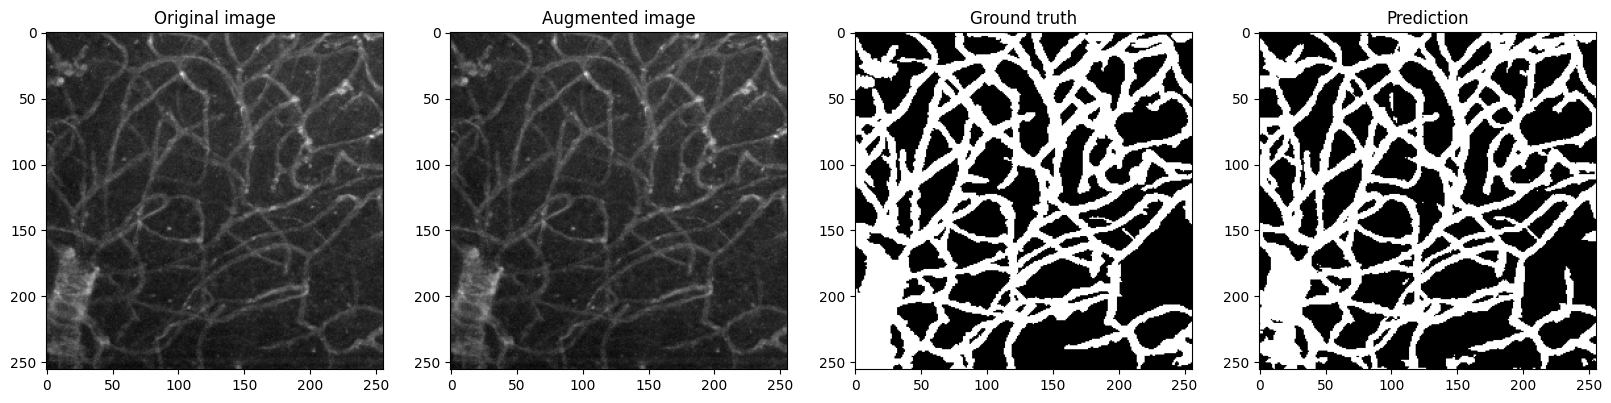

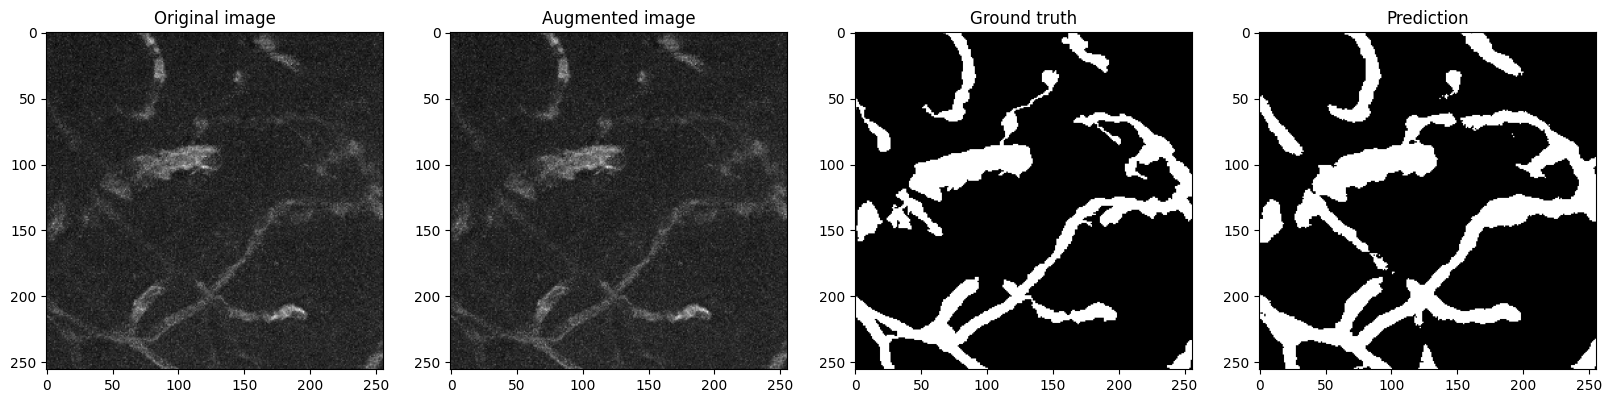

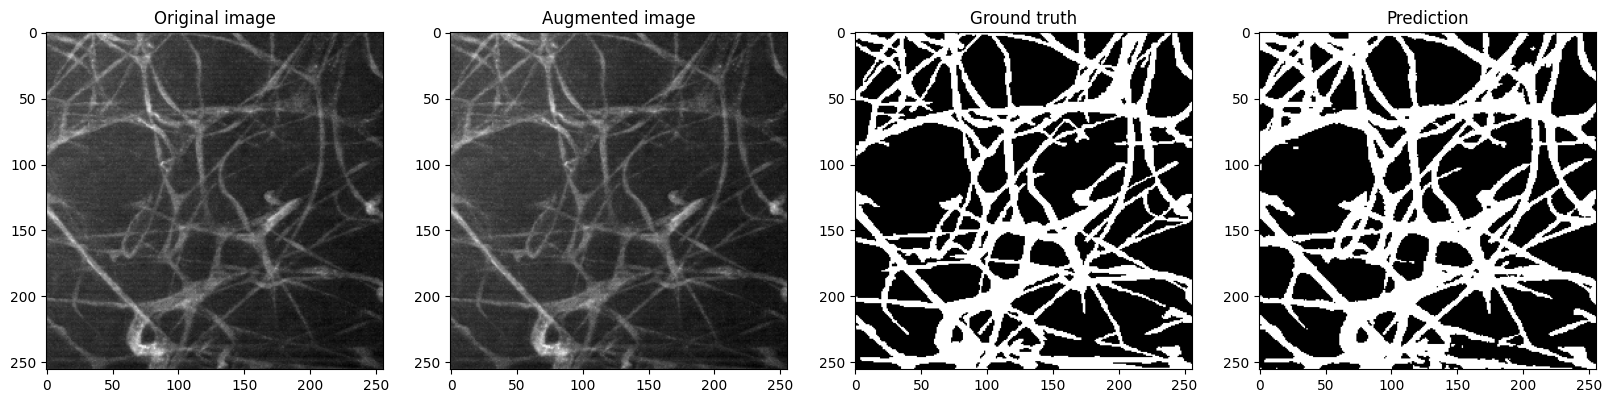

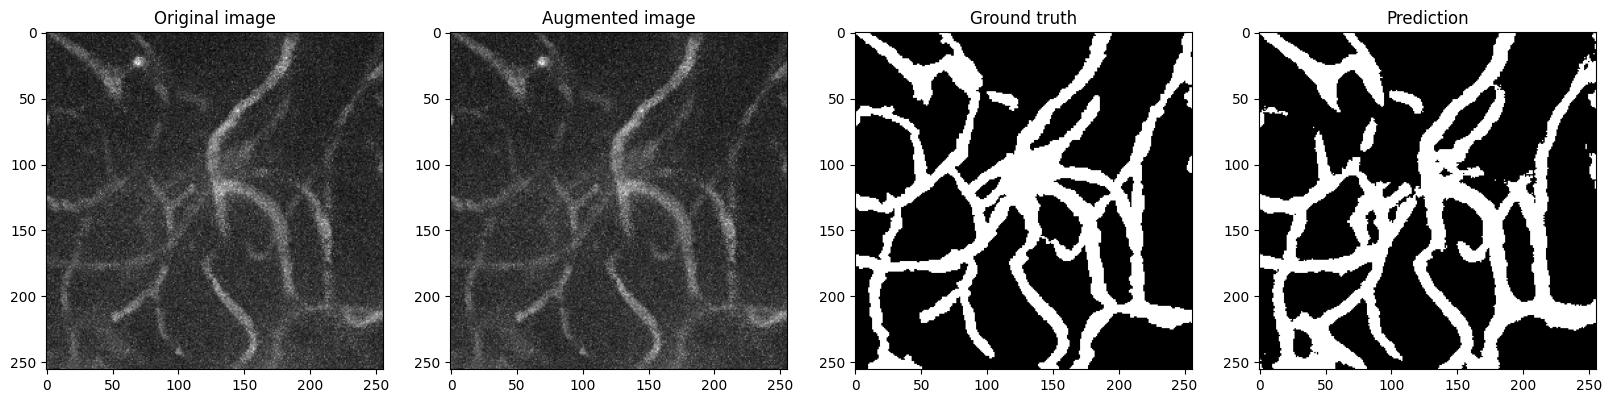

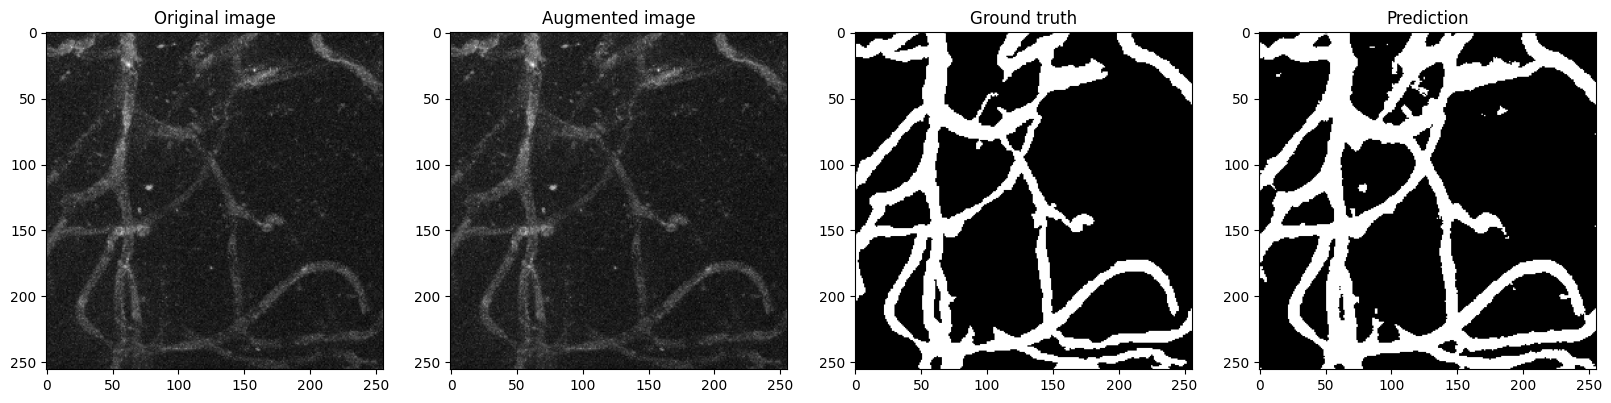

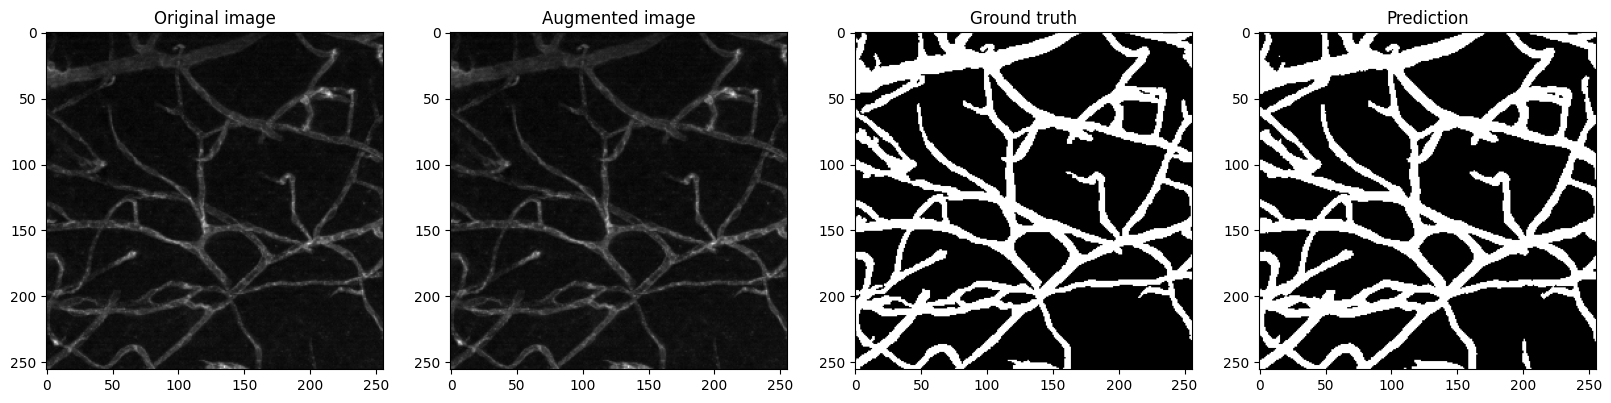

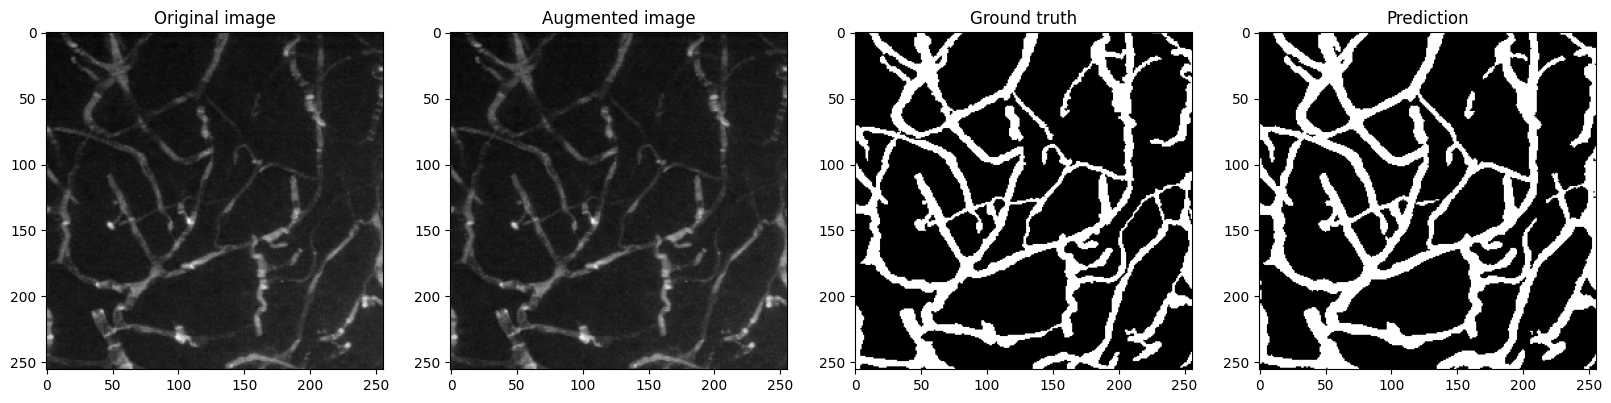

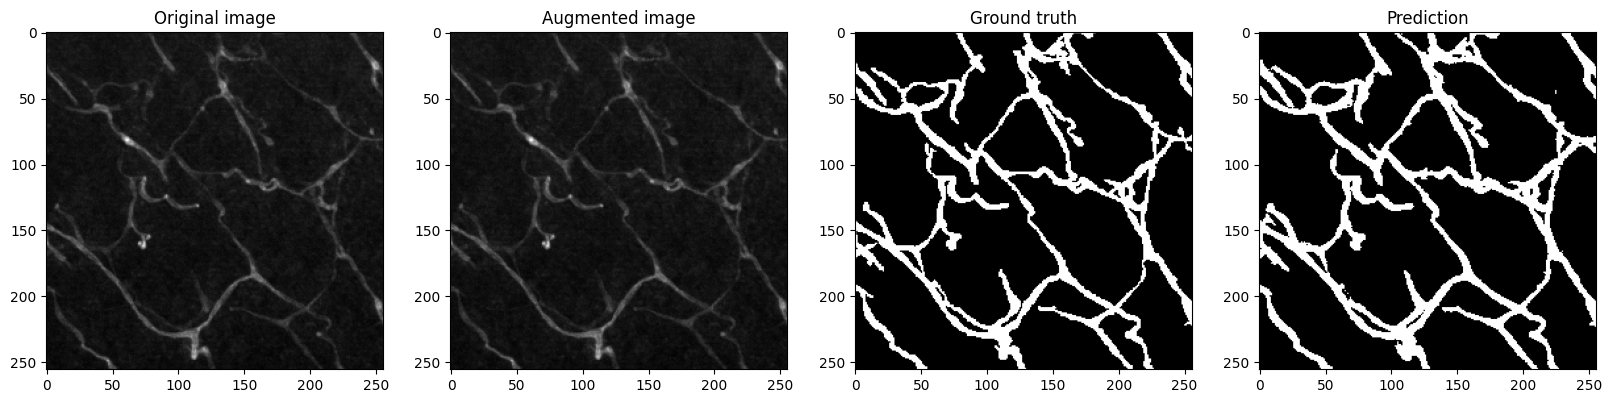

In [8]:
# Plot results
def plot_metrics(logger):
    '''Plot losses and IoU.''' 
    
    epochs, metrics = zip(*logger.data.items())
    train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0., 0.4))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0., 1.))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=10):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)  # Randomly draw some indices
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

plot_metrics(logger)
plot_examples(ds_valid, model)

### Lightning experiments

In [ ]:
# Plot results
def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 'rec']]
        train_loss, valid_loss, iou, prec, rec = metrics    


    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0.6, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

plot_metrics(logger, type='lt')
plot_examples(ds_valid, model)